In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# torch.manual_seed(1)

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
import pickle

In [4]:
# input_size = 2 
hidden_size = 2048 # randomly chosen
output_size = 1 # we want it to return a number that can be used to calculate the difference from the actual number

class NeuralNetwork(nn.Module):
    def __init__(self,img_dim, output_size):
        
        super(NeuralNetwork, self).__init__()
        
        
        # weights 
#         self.W = torch.randn(img_dim,img_dim , requires_grad=True)

#         self.theta_D = torch.randn(num_img, img_dim, requires_grad=True)
        
        
        self.W = nn.Linear(img_dim,img_dim)
        
        self.discriminator_thetaD = nn.Linear(img_dim,hidden_size)
        self.discriminator_hiddn = nn.Linear(hidden_size,output_size)


        
# Add bias
        self.b1 = torch.randn(img_dim, requires_grad=True)

#         self.b2 = torch.randn(hidden_size, requires_grad=True)
#         self.b3 = torch.randn(output_size, requires_grad=True)
        
        
    def forward(self, inp_matrix,phase='Discriminate',typeinp='img'):
        
        if phase == 'Discriminate' and typeinp=='img':

            self.W.trainable = False
            self.discriminator_thetaD.trainable = True
            self.discriminator_hiddn.trainable = True
            
            
            wTx = self.W(inp_matrix)

            
            discriminator_hidden_in = self.discriminator_thetaD(wTx)
            out = self.discriminator_hiddn(discriminator_hidden_in)
            out=out.view(-1)

            return nn.Sigmoid()(out)

        if phase == 'Discriminate' and typeinp=='text':

            self.W.trainable = False
            self.discriminator_thetaD.trainable = True
            self.discriminator_hiddn.trainable = True
            
            
#             wTx = self.W(img)

            
            discriminator_hidden_in = self.discriminator_thetaD(inp_matrix)
            out = self.discriminator_hiddn(discriminator_hidden_in)
            out=out.view(-1)

            return nn.Sigmoid()(out)

        if phase == 'Map' and typeinp=='img' :
            self.W.trainable = True
            
            wTx = self.W(inp_matrix)
            
            self.discriminator_thetaD.trainable = True
            self.discriminator_hiddn.trainable = True
            
            
            discriminator_hidden_in = self.discriminator_thetaD(wTx)
            out = self.discriminator_hiddn(discriminator_hidden_in)
            out = out.view(-1)
            return nn.Sigmoid()(out)
            
        if phase == 'Map' and typeinp=='text' :
            self.W.trainable = True
            
#             wTx = self.W(inp_matrix)
            
            self.discriminator_thetaD.trainable = True
            self.discriminator_hiddn.trainable = True
            
            
            discriminator_hidden_in = self.discriminator_thetaD(inp_matrix)
            out = self.discriminator_hiddn(discriminator_hidden_in)
            out = out.view(-1)
            return nn.Sigmoid()(out)

            


In [5]:
dimension_space = 300

nne = NeuralNetwork(dimension_space,1).cuda()

In [6]:

learning_rate = 0.01

# create a stochastic gradient descent optimizer
# optimizer = optim.SGD(nne.parameters(), lr=learning_rate, momentum=0.9)

# optimizer = optim.Adam([var1, var2], lr = 0.0001)

optimizer = optim.Adam(nne.parameters(), lr = 0.0001)

# create a loss function
criterion = nn.BCELoss().cuda()

In [7]:
nne

NeuralNetwork(
  (W): Linear(in_features=300, out_features=300, bias=True)
  (discriminator_thetaD): Linear(in_features=300, out_features=2048, bias=True)
  (discriminator_hiddn): Linear(in_features=2048, out_features=1, bias=True)
)

In [8]:
import numpy as np

# num_instances = 30000

# input_img = np.random.rand(num_instances,300)
# input_text = np.random.rand(num_instances,300)

with open("ques_matrix.pickle","rb") as fh:
    input_text = pickle.load(fh)

with open("imgs_matrix.pickle","rb") as fh:
    input_img = pickle.load(fh)
    
num_instances = len(input_img)

In [9]:
input_img

array([[ 2.349762  ,  2.2534468 ,  0.5039957 , ..., -0.7935544 ,
         0.02391236, -0.8734526 ],
       [ 2.349762  ,  2.2534468 ,  0.5039957 , ..., -0.7935544 ,
         0.02391236, -0.8734526 ],
       [ 2.349762  ,  2.2534468 ,  0.5039957 , ..., -0.7935544 ,
         0.02391236, -0.8734526 ],
       ...,
       [-6.1800056 ,  0.33435112,  0.4804101 , ..., -0.02356215,
         0.02870018,  0.4167842 ],
       [-6.1800056 ,  0.33435112,  0.4804101 , ..., -0.02356215,
         0.02870018,  0.4167842 ],
       [-6.1800056 ,  0.33435112,  0.4804101 , ..., -0.02356215,
         0.02870018,  0.4167842 ]], dtype=float32)

In [10]:
num_epochs = 35

In [11]:
discriminator_img_loss = []
discriminator_text_loss = []
mapper_loss = []
mapper_text_loss = []

In [12]:
for epoch in range(num_epochs):
    
    ## Discriminate. For image, it is 1, saying it comes from different distribution
    outed = nne( Variable(torch.from_numpy(input_img)).cuda().float(),phase='Discriminate',typeinp='img')
    
    targets = (torch.ones(num_instances).cuda()).fill_(0.8)  # Smoothing suggested by GoodFellow
    
    loss = criterion(outed,targets)
    discriminator_img_loss.append(loss.cpu().tolist())
    loss.backward()
    optimizer.step()

    ## Discriminate. For text, it is 0 saying it is text, from same distribution 
    outed = nne( Variable(torch.from_numpy(input_text)).cuda().float(),phase='Discriminate',typeinp='text')
    targets = (torch.zeros(num_instances).cuda()).fill_(0.2)
    
    loss = criterion(outed,torch.zeros(num_instances).cuda())
    
    
    discriminator_text_loss.append(loss.cpu().tolist())
    loss.backward()
    optimizer.step()

    ## Mapper , Training in a way to fool discriminator think that vector from image distribution is from text distribution. 
    outed = nne( Variable(torch.from_numpy(input_img)).cuda().float(),phase='Map',typeinp='img')
    loss = criterion(outed,torch.zeros(num_instances).cuda())
    mapper_loss.append(loss.cpu().tolist())
    loss.backward()
    optimizer.step()
    
    ## Mapper , Training in a way to fool discriminator think that vector from text distribution is from image distribution. 

#     outed = nne( Variable(torch.from_numpy(input_img)).cuda().float(),phase='Map',typeinp='text')
#     loss = criterion(outed,torch.ones(num_instances).cuda())
#     mapper_text_loss.append(loss.cpu().tolist())
#     loss.backward()
#     optimizer.step()
    
    

In [13]:
# discriminator_img_loss

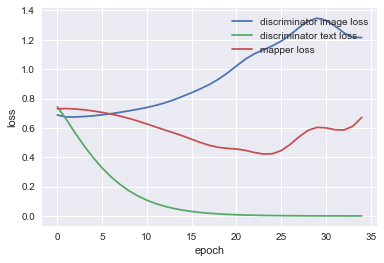

In [14]:
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot([i for i in range(num_epochs)],discriminator_img_loss,label='discriminator image loss')
plt.plot([i for i in range(num_epochs)],discriminator_text_loss,label='discriminator text loss')
plt.plot([i for i in range(num_epochs)],mapper_loss,label='mapper loss')
# plt.plot([i for i in range(num_epochs)],mapper_text_loss,label='mapper text loss')
plt.legend(loc='upper right')

## tSNE demo

In [ ]:
from sklearn.manifold import TSNE


In [ ]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')


In [ ]:
import numpy as np
# test_inp = np.random.rand(1000,300)

In [ ]:
tsne_lda = tsne_model.fit_transform(input_text)

In [ ]:
import numpy as np
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool

n_top_words = 5 # number of keywords we show

# 20 colors
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

In [ ]:
num_example = test_inp.shape[0]
title='visual trials'
plot_lda = bp.figure(plot_width=1400, plot_height=1100,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1],source=bp.ColumnDataSource({"content": test_inp,}))



In [ ]:
# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - topic: @topic_key"}

# save the plot
save(plot_lda, '{}.html'.format(title))

# Just checking the updatability property

In [ ]:
outed = nne( Variable(torch.from_numpy(input_img)).cuda().float(),phase='Discriminate')

In [ ]:
nne.W.weight

In [ ]:
nne.discriminator_thetaD.weight

In [ ]:
nne.discriminator_hiddn.weight

In [ ]:
outed.shape

In [ ]:
loss = criterion(outed,torch.ones(1000))
loss.backward()
optimizer.step()

In [ ]:
nne.W.weight

In [ ]:
nne.discriminator_thetaD.weight